<table width=100%>
<tr>
    <td><h1 style="text-align: left; font-size:250%;">
        Analysis of the TCGA gene expression data using classification techniques
    </h1></td>
    <td width="20%">
    <div style="text-align: right">
    <font color="#728FA5" size = "2">
        Project 7 -  
        Scientific Programming Course </font 
        <br> <br> <br>
        <font face=”Arial,Helvetica,sans-serif” size = "3"> <b> Eleonora Cianini </font </b> <br>
        <br>
    <a></a>
    </div>
    </td>
    <td width="150px"> 
        <a>
         <img align="right", width="150px" height ="150px"
 src="https://upload.wikimedia.org/wikipedia/it/b/be/Logo_Politecnico_Milano.png" alt="Logo Politecnico di Milano"/>
        </a>
    </td>
</tr>
                                                                                      
</table>

<p>
<b> Introduction</b>
<ol>
    <il><b> 1. Data preparation </b></il><br>
    <ol>
        <il> 1.1 Data loading</il><br>
    </ol>
    <il><b> 2. Exploratory Data Analysis </b></il><br>
    <ol> 
        <il> 2.1 Sample distribution </il><br>
        <il> 2.2 Principal Component Analysis (PCA) </il><br>
        <il> 2.3 Data filtering </il><br>
    </ol>
    <il><b> 3. Classification </b></il><br>
    <ol> 
        <il> 3.1 PCA evaluation</il><br>
        <il> 3.2 Multi-model evaluation</il><br>
        <il> 3.3 Hyper-parameters tuning </il><br>
    </ol>
    <b><b> Conclusions </b><br>

# Introduction

In this notebook we will analize data of breast invasive carcinoma coming from the **BRCA** project of **The Cancer Genome Atlas Program ([TCGA](https://www.cancer.gov/about-nci/organization/ccg/research/structural-genomics/tcga))**, a landmark for cancer genomics program and molecular characterization.

The aim of this project is to analyze data using some of the most popular machine learning algorithms in order to predict the status of the patients based on the gene expression values.

# 1. Data preparation 

The data are downloaded from [GenoSurf](http://geco.deib.polimi.it/genosurf/) interface using these filters:
* project_name: ['tcga-brca']
* assembly: ['grch38']
* data_type:['gene expression quantification']
* is_healthy:
    * ['false'] for tumoral data
    * ['true'] for normal data.

The tumoral data consist in 1108 samples while the healthy ones are 113, for a total of 1221 samples.

Each file contains two URL links for each sample: one represents the region file and the other the metadata file.

The region file contains the genomic information whereas the metadata contains additional information such as the classification status of the sample. 

## 1.1 Data loading

In [1]:
#import the libraries 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import os
import warnings

In [2]:
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score, precision_score, recall_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

In [3]:
#import the healthy samples
healthy_df = pd.read_table("healthy.txt", header = None, names = ['url'])

#import the tumoral samples 
tumoral_df = pd.read_table("tumoral.txt", header = None, names = ['url'])

Since both the healthy and the tumoral files contain two url links for each sample, we filter them selecting only the 'region' file

In [4]:
def filter_url(notfiltered_df, string):
    df_filtered = []
    for i in range (0, len(notfiltered_df['url'])):
        if str(string) in notfiltered_df['url'][i]:
            df_filtered.append(str(notfiltered_df['url'][i]))
    return df_filtered

healthy_df_filtered = filter_url(healthy_df, 'region')
print(f'The number of region files in heatlhy samples is: {len(healthy_df_filtered)}')
tumoral_df_filtered = filter_url(tumoral_df, 'region')
print(f'The number of region files in heatlhy samples is: {len(tumoral_df_filtered)}')


The number of region files in heatlhy samples is: 113
The number of region files in heatlhy samples is: 1108


Now is possible to proceed with the download of the region file.

The choice to not proceed to download also the **metadata file** has its roots on the fact that, since the files are downloaded separately from the beginning (on the basis of the <code>is_healthy</code> filter), we already know which are tumoral samples and which are healthy and so we do not need to "look" at metadata informations.

It is known that pandas can read csv coming from url, but this always requires an internet connection, so the choice of the local download seemed the most reasonable.



NB. Before executing the following code, two folders for data storage need to be created in the working directory.



In [5]:
# download and save the file in a specific directory 
def download_urls(df_filtered, directory):
    for i in range (0, len(df_filtered)):
        url = df_filtered[i]
        samplename = url.split('/')[-2] 
        r=requests.get(url, stream=True)
        if r.status_code == requests.codes.ok:
            pwd= os.getcwd()
            path = pwd + '\\'+ str(directory) +'\\' + str(samplename)
            with open(path, 'wb') as f:
                for data in r:
                    f.write(data)

Uncomment the following line to proceed with the download:

In [6]:
#healthy 
#download_urls(healthy_df_filtered, 'healthy')
#print('download completato')

#tumoral
#download_urls(tumoral_df_filtered, 'tumoral')
#print('download completato')

Create the dataframes using *ensembl_gene_id* as header and *fpkm* as value.

In [7]:
def read_files(directory):
    names = ['chromosome', 'start', 'end', 'strand', 'ensembl_gene_id', ' entrez_gene_id', 'gene_symbol', 'type', 'htseq_count',
         'fpkm_uq', 'fpkm']

    df = pd.DataFrame()

    pwd= os.getcwd()
    path = pwd + '\\' + str(directory) + '\\'
    list_file = os.listdir(path)

    for i in range (0, len(list_file)):
        dir_file = path + str(list_file[i])
        csv = pd.read_csv(dir_file, sep = "\t", header = None, names = names)
        csv = pd.pivot_table(csv, values='fpkm', index = 'ensembl_gene_id').T
        df = df.append(csv)
    return df

Add the information about the samples "status"

In [8]:
#healthy
df_healthy = read_files('healthy')

# add a column with the status 
df_healthy['tumoral'] = '0'
df_healthy

ensembl_gene_id,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1,tumoral
fpkm,15.038070,14.759733,20.942462,2.805225,0.782528,5.423555,61.054026,22.180747,8.665240,7.745427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,19.098676,1.840548,24.999732,2.361720,0.658365,2.919658,18.843594,21.831677,4.984072,9.481791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,16.562323,5.735467,28.684468,4.237798,1.194246,3.165928,9.460746,19.771322,5.014253,13.666273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,17.383716,7.613039,20.921766,3.277933,0.724987,1.665395,4.546932,14.745758,8.509043,9.399467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,23.881664,1.902087,33.964024,5.563749,1.394149,2.440051,10.064257,12.852097,5.983627,16.166428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm,15.835176,10.647419,24.299356,2.543213,0.546890,1.032122,14.613814,13.090202,12.086735,9.847241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,18.388907,10.913003,25.364233,3.733386,0.982795,9.457156,11.154218,16.549261,6.340117,11.419784,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,14.813995,41.727618,19.302400,2.213386,0.700564,5.182210,32.169290,24.532456,9.121531,5.757474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
fpkm,23.555354,3.053871,26.403025,6.356077,1.113224,1.877431,4.356138,12.976491,7.192146,12.817168,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [9]:
#tumoral 
df_tumoral = read_files('tumoral')

#add a column with the status 
df_tumoral['tumoral'] = '1'
df_tumoral

ensembl_gene_id,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1,tumoral
fpkm,21.802661,0.186906,37.578928,8.083003,2.781439,0.926171,2.171244,16.940115,3.313641,15.485401,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,4.235466,1.325593,30.119492,4.355058,1.077068,2.296780,4.645011,19.172618,5.295792,11.970247,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,15.752438,0.070065,30.681041,4.558432,2.579139,0.885994,9.453277,24.492556,10.038721,17.848583,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,3.293008,0.000000,58.790723,10.826620,4.237957,0.723620,10.267555,14.035519,7.514246,20.990645,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,8.230043,0.014399,25.429291,4.324549,2.066851,0.734034,4.405887,9.096894,8.540933,15.846097,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fpkm,8.534925,1.275444,23.962606,2.772298,1.587575,2.040952,10.367577,26.814668,5.443385,12.276079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,33.778203,0.092764,57.867768,5.986377,13.927506,1.007901,2.112773,25.690930,4.360894,49.082549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,6.366955,0.586589,35.453655,3.774370,2.524568,3.823734,5.432521,65.775424,6.841912,15.181490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
fpkm,5.670638,0.000000,27.774229,7.714313,2.252915,2.023873,5.397548,28.262694,3.426822,22.280552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


This method is not very automated, however it has avoided downloading and reading more than 1000 files.

In [10]:
# concatenate
samples = pd.concat([df_healthy, df_tumoral])

# save to csv
samples.to_csv(path_or_buf="./tgca_gene_expression.csv", index=False, header=True)

Create the <code>csv</code> file avoids to run every time all the previous lines of code.

In [11]:
#read the csv.file
df = pd.read_csv("tgca_gene_expression.csv")
df

,ENSG00000000003.13,ENSG00000000005.5,ENSG00000000419.11,ENSG00000000457.12,ENSG00000000460.15,ENSG00000000938.11,ENSG00000000971.14,ENSG00000001036.12,ENSG00000001084.9,ENSG00000001167.13,...,ENSGR0000264510.4,ENSGR0000264819.4,ENSGR0000265658.4,ENSGR0000270726.4,ENSGR0000275287.3,ENSGR0000276543.3,ENSGR0000277120.3,ENSGR0000280767.1,ENSGR0000281849.1,tumoral
0,15.038070,14.759733,20.942462,2.805225,0.782528,5.423555,61.054026,22.180747,8.665240,7.745427,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,19.098676,1.840548,24.999732,2.361720,0.658365,2.919658,18.843594,21.831677,4.984072,9.481791,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,16.562323,5.735467,28.684468,4.237798,1.194246,3.165928,9.460746,19.771322,5.014253,13.666273,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,17.383716,7.613039,20.921766,3.277933,0.724987,1.665395,4.546932,14.745758,8.509043,9.399467,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,23.881664,1.902087,33.964024,5.563749,1.394149,2.440051,10.064257,12.852097,5.983627,16.166428,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1216,8.534925,1.275444,23.962606,2.772298,1.587575,2.040952,10.367577,26.814668,5.443385,12.276079,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1217,33.778203,0.092764,57.867768,5.986377,13.927506,1.007901,2.112773,25.690930,4.360894,49.082549,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1218,6.366955,0.586589,35.453655,3.774370,2.524568,3.823734,5.432521,65.775424,6.841912,15.181490,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1219,5.670638,0.000000,27.774229,7.714313,2.252915,2.023873,5.397548,28.262694,3.426822,22.280552,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [12]:
# samples values
X = df.drop('tumoral', axis = 1)

#check and remove the rows with zero expression
print(X.any().value_counts())  #2209 features have zero expression
X_notzero = X.loc[:, X.any()] 

# status 
y = df.loc[: ,['tumoral']].copy() 
#y = y.values.ravel()

True     58274
False     2209
dtype: int64


 # 2. Exploratory data analysis 

In [13]:
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, KFold, cross_val_score
from sklearn.feature_selection import VarianceThreshold,SelectKBest, f_classif
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score, plot_confusion_matrix, f1_score, precision_score, recall_score, make_scorer
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier

## 2.1 Samples distribution

Analyze the percentage of healthy and tumor samples

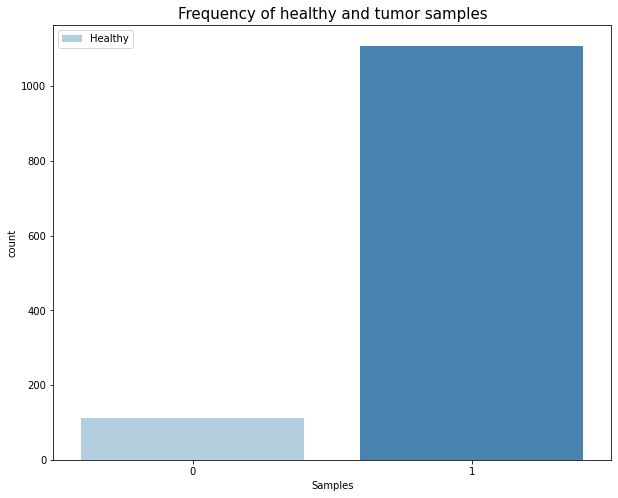

,tumoral,Counts
1,1,1108
0,0,113


In [14]:
#visualize the distribution of the samples in each class
plt.figure(figsize=(10, 8))
fig1 = sns.countplot(data = df, x = 'tumoral', palette = "Blues")
fig1.set_title('Frequency of healthy and tumor samples', fontsize = 15) #title
fig1.legend(labels = ['Healthy'])
fig1.set_xlabel('Samples')
plt.show()

#count the number of samples for each class
df.groupby("tumoral").size().reset_index(name='Counts').sort_values(by="Counts", ascending =False)


This dataset is very unbalanced: most of the samples are tumoral while only 1/10 are healthy.

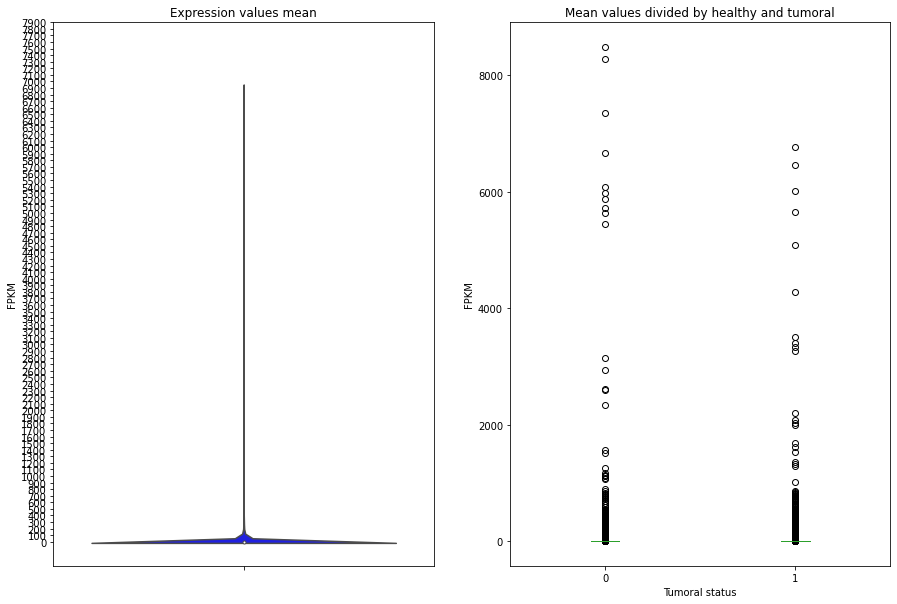

In [15]:
fig, axs = plt.subplots(1,2, figsize = (15,10))
#violin plot
sns.violinplot(X_notzero.mean(axis=0), orient = 'v', color = 'b', ax= axs[0])
axs[0].set_yticks(np.arange(0, 8000, step=100))
axs[0].set_title("Expression values mean")
axs[0].set_ylabel("FPKM")


#box plot
df.groupby('tumoral').mean().T.boxplot(ax = axs[1])
axs[1].grid(False)
axs[1].set_xlabel('Tumoral status')
axs[1].set_ylabel("FPKM")
axs[1].set_title("Mean values divided by healthy and tumoral")
plt.show()

From the violin plot we can see that most of the genes have a very low mean expression value, between 0 and 100 fpkm.

In the box plot is possible to notice that, healthy samples seems to have an higher mean expression value if compared to tumor ones (class 1), but in general, in both the majority of the sample is below 2000 fpkm. 

## 2.2 Feature selection

As well as being highly unbalanced, the dataset contains a very large number of features (about 58000) and so in the following steps we are going to apply technique for **feature selection**.

Reduce the number of feature is important both to **reduce the computational cost** of modeling and to **improve the performance** of the model avoiding the **overfitting** (i.e. when a model learns the details and noise in the training data, having a negative impact on the performance of the model on new data).

The feature selection will be performed using the *filter methods* that is summarized in the figure below.
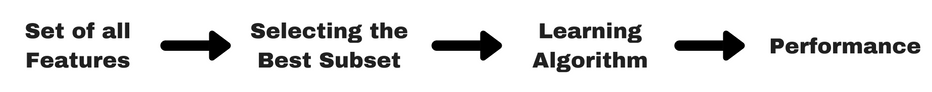




In that case the feature selection is done firstly by applying  a **variance threshold** in order to eliminate features with similar variance and then by performing an **F-test**.

### Split in train and test dataset 

Since no train and test data are provided, we have to split the data into train and test sets in order to perform the following analysis.

In [16]:
#splitting 
X_train, X_test, y_train, y_test = train_test_split(X_notzero, y,
                                                    test_size=0.33, 
                                                    random_state=42)

X_train.shape, X_test.shape

((818, 58274), (403, 58274))

### Remove quasi constant features

Constant features show similar/single values in all the observations in the dataset. These features provide no information that allows ML models to predict the target in a more accurate way.

The <code>VarianceThreshold</code> by default eliminates the zero variance features, but since the dataset is very big, the threshold has been increased to 0.8 (instead of 0).

In [17]:
q_constant_filter = VarianceThreshold(threshold = 0.8)
q_constant_filter.fit(X_train)
X_train_var = q_constant_filter.transform(X_train)
X_test_var = q_constant_filter.transform(X_test)

In [18]:
X_train_var.shape

(818, 19145)

### F-test
To perform the test we use the <code>f_classif</code> method in order to find and select only the relevant features having p-**value < 0.01**.

In [19]:
sel = f_classif(X_train_var, y_train.values.ravel()) 

In [20]:
#to dataframe
X_train = pd.DataFrame(X_train_var)
X_test = pd.DataFrame(X_test_var)

In [21]:
p_values = pd.Series(sel[1]) #second array
p_values.index = X_train.columns
p_values.sort_values(ascending = True, inplace = True)

In [22]:
#significant features
p_values = p_values[p_values < 0.01]
len(p_values)

9494

In [23]:
X_train_p = X_train[p_values.index]
X_test_p = X_test[p_values.index]

Using filter methods from almost 58000 feature we ended up with **9494** features representing almost the 15% of the original features.

## 2.3 Principal Component Analysis

<p> Before using classification algorithms, we perform also dimensionality reduction using the <b>Principal Component Analysis</b>.<br>
    PCA is an algorithm useful for filter, select important features and visualize high dimensional data in a 3D space by transforming the features into a new set of features orthogonal to each other.<br> <br>
    Since PCA provides a comparison between the explained variances in the dataset, data should be <b>normalized</b> in order to avoid giving too much importance to a variable instead of another just because they are not in the same scale.<br> <br>
    To reach this first purpose we use and compare the performance, in terms of <b>cumulative expressed variance</b>, of two algorithms: the <code>StandardScaler</code> and the <code>MinMaxScaler</code> from <code>scikit-learn</code> package. <br><br>
    <b>Reminder</b>: the following analysis are performed on the reduced dataset.

In [24]:
#scaling since PCA is based on distance 
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#StandardScaler makes mean = 0 and scales the data to unit variance
X_ss = StandardScaler().fit_transform(X_train_p)
#MinMax scales all the data features in the range [0,1]
X_mm = MinMaxScaler().fit_transform(X_train_p)

In [25]:
def pca_varexp(X, title):
    pca = PCA().fit(X)
    fig = plt.figure(figsize=(15,6))
    ax = fig.add_subplot(111)
    plt.plot(np.cumsum(pca.explained_variance_ratio_), color="cadetblue", linewidth=5.0)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title(title)
    major_ticks = np.arange(0, X.shape[0], 100)
    minor_ticks = np.arange(0, X.shape[0], 10)
    ax.set_xticks(major_ticks)
    ax.set_xticks(minor_ticks, minor=True)
    plt.grid()
    plt.show()

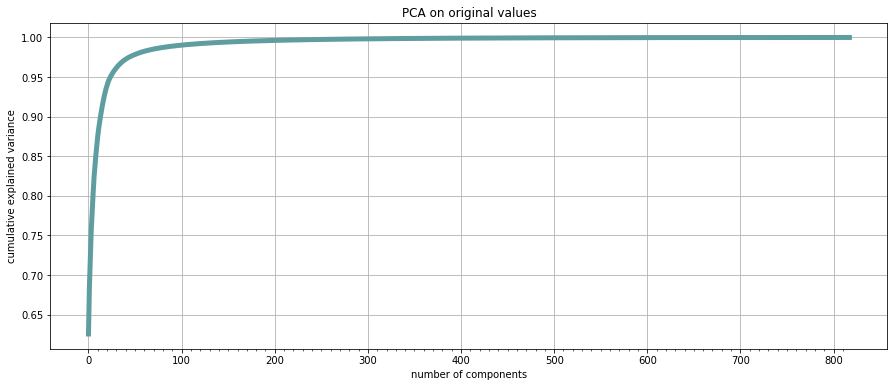

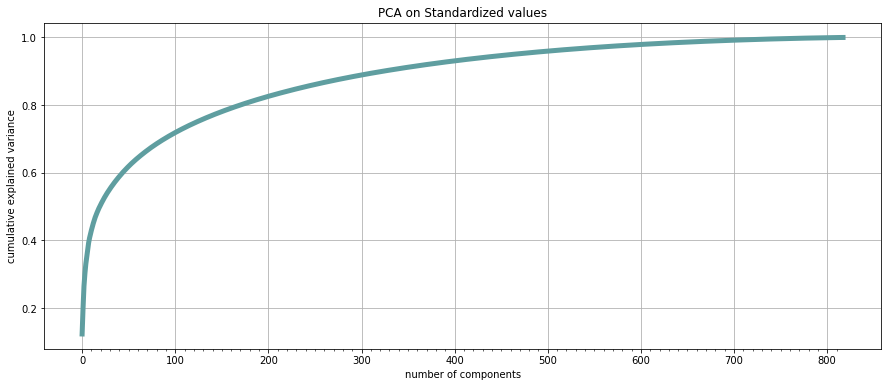

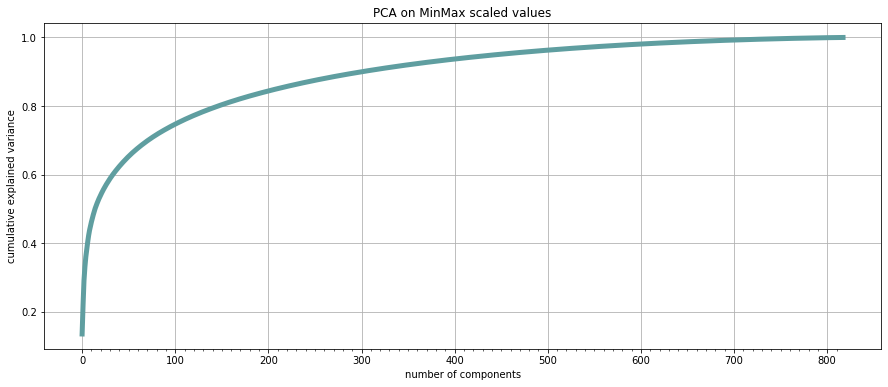

In [26]:
pca_varexp(X_train_p, "PCA on original values")
pca_varexp(X_ss, "PCA on Standardized values")
pca_varexp(X_mm, "PCA on MinMax scaled values")

From the graphs we can see that the two scaled curves are very similar between each other and for both is necessary an **high number of components** to explain the **80%** of the **variance**.

For the following analysis we will take into account the MinMax scaled value.

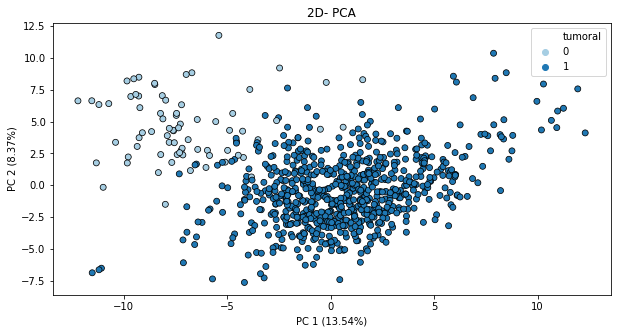

In [27]:
#2D-PCA
pca = PCA(n_components=2)
projected2 = pca.fit_transform(X_mm)

fig = plt.figure(figsize=(10,5))
sns.scatterplot(projected2[:, 0], projected2[:, 1], hue=y_train['tumoral'], edgecolor='k',
                palette=sns.color_palette("Paired", n_colors=np.unique(y).shape[0]))
plt.xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
plt.ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
plt.title("2D- PCA")
plt.show()

We can see that most points are distibuted in a cloud spread along the first axis; the ones that diverge more along the 2nd axis are healthy patients. 

Healthy and cancer samples are more or less clustered in two quite distinct groups.
We can add the 3rd dimension (that explains another 7% of the variation) to have a more clear distinction of the data points.

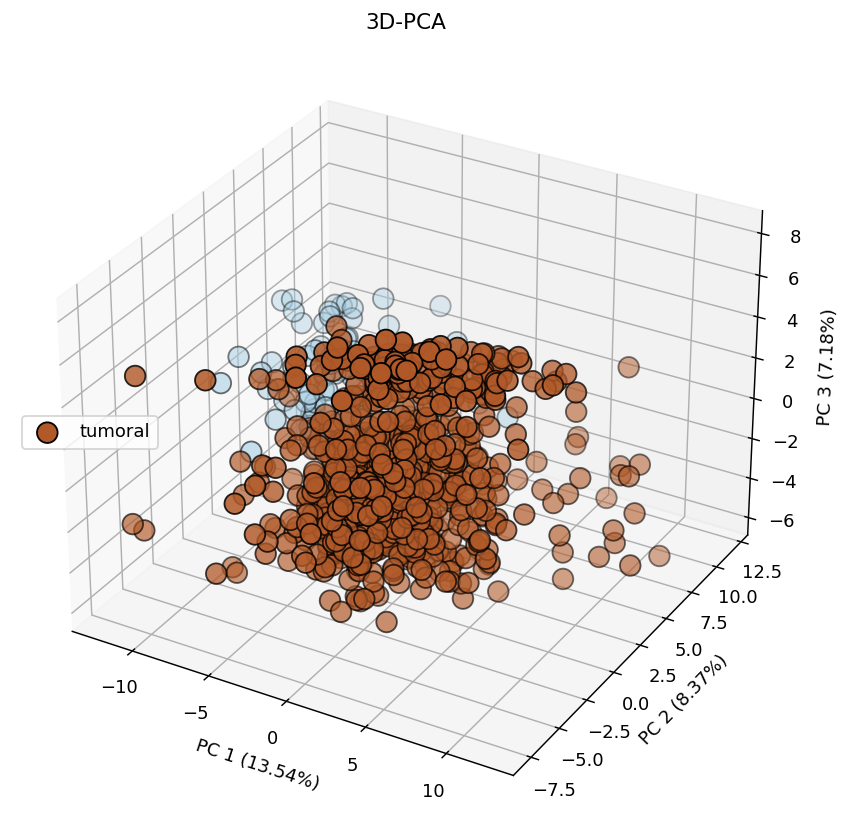

In [28]:
#3D-PCA
pca = PCA(n_components=3)
pca.fit(X_mm)
X_trans = pca.transform(X_mm)


fig = plt.figure(figsize=(8, 8), dpi=130)
ax = fig.add_subplot(111, projection='3d')

sc = ax.scatter(X_trans[:, 0], X_trans[:, 1], X_trans[:, 2], c=y_train["tumoral"], 
                cmap=plt.cm.get_cmap("Paired"), edgecolor='k', s=130, label = "tumoral")
# label the axes
ax.set_xlabel('PC 1 (%.2f%%)' % (pca.explained_variance_ratio_[0]*100))
ax.set_ylabel('PC 2 (%.2f%%)' % (pca.explained_variance_ratio_[1]*100))
ax.set_zlabel('PC 3 (%.2f%%)' % (pca.explained_variance_ratio_[2]*100))
ax.legend(("tumoral", "healthy"), loc = "center left")
ax.set_title("3D-PCA")
plt.show()

We can see that the distinction between cancer and healthy patitents is somewhat clearer in 3 dimensions with some divergent points probably due to the heterogeneity of cancer samples.

The first **3 components** show about **30%** of the train dataset variability.

# 3. Classification

After reduced the complexity of the dataset using the filter methods for feature selection we decided to train classification models using the 6 canonical classification algorithms:

1. Logistic Regression
2. SVC with linear kernel
3. SVC with polynomial kernel
4. K Nearest Neighbours
5. Linear Discriminant Analysis
6. Quadratic Discriminant Analysis

Those were firstly applied to the dimensionality reduced data coming from PCA and after they were used directly to the filtered data in order to understand who performed best.
At the end, we made an hyper-parameter tuning of the best models in order to maximaze the accuracy.

To better evaluate our models we performed k-fold cross validation with k=10. In this way the dataset is divided in k sections, the models are trained on k-1 sections and are tested on 1. Therefore the models are trained k times. This technique allows to have better estimates of the performance of the model.

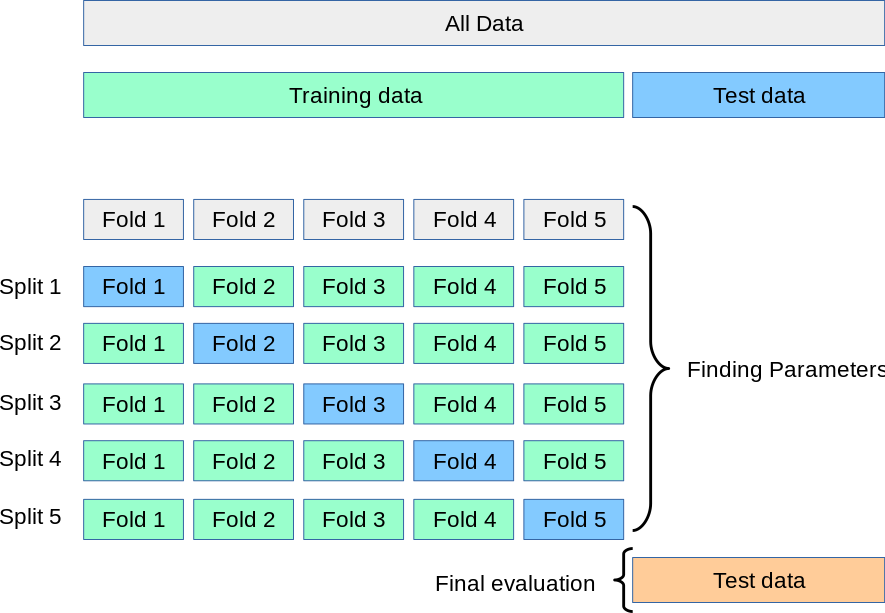

After training the models we assessed their performances on the basis of a confusion matrix for each model and the accuracy of each kfold of each model.
In addiction f-score, recall and precision for each class was produced. This was done to judge the models with other metrics especially useful when considering a severly imbalanced dataset like ours.

In particular:
* 
\begin{equation} \label{eq:Precision}
  PRECISION = TruePositive  \ (TruePositive + FalsePositive) 
\end{equation} 

                                    It quantifies the number of correct positive predictions made

* 
\begin{equation} \label{eq:Recall}
  RECALL = TruePositive  \ (TruePositive + FalseNegatives) 
\end{equation} 

                     It quantifies the number of correct positive predictions made out of all positive predictions 
* 
\begin{equation} \label{eq:Fscore}
  F-SCORE = 2(Precision * Recall) \ (Precision + Recall) 
\end{equation}
         
                                             It combines precision and recall


In [29]:
#define some useful thing

In [30]:
#define models
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
linear_SVC = SVC(kernel='linear', probability = True)
poly_SVC = SVC(kernel='poly', probability =True)
knn = KNeighborsClassifier(n_neighbors=10)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

from collections import OrderedDict
models = OrderedDict([('logreg', logreg), ('linear_SVC', linear_SVC), ('poly_SVC', poly_SVC),
                      ('knn', knn), ('lda', lda), ('qda', qda)])

warnings.filterwarnings('ignore')

In [31]:
def accuracy_plot (cv_scores, accuracy_test_scores):
    
    data = pd.DataFrame()
    data['model'] = list(models.keys())*2
    data['metric'] = ['10-cv accuracy'] * len(cv_scores) + ['test accuracy'] * len(accuracy_test_scores)
    data['score'] =  cv_scores + accuracy_test_scores

    plt.figure(figsize=(8,8))
    ax = sns.barplot(x='model', y='score', data=data, hue='metric',
                palette = "Set2")
    ax.bar_label(ax.containers[0])
    ax.bar_label(ax.containers[1])
    ax.legend(loc='lower right')
    ax.set_title('Accuracy scores')
    plt.show()

## 3.1 PCA for feature selection

For the classification using PCA as technique for dimensionality reduction, we have chosen the **first 30 PCs** because they show about **80%** of the total **variability** (taking into account the original data).

logreg CV Accuracy : 0.9756, Test Accuracy :  0.8710
              precision    recall  f1-score   support

     healthy       0.16      0.08      0.10        39
     tumoral       0.91      0.96      0.93       364

    accuracy                           0.87       403
   macro avg       0.53      0.52      0.52       403
weighted avg       0.83      0.87      0.85       403



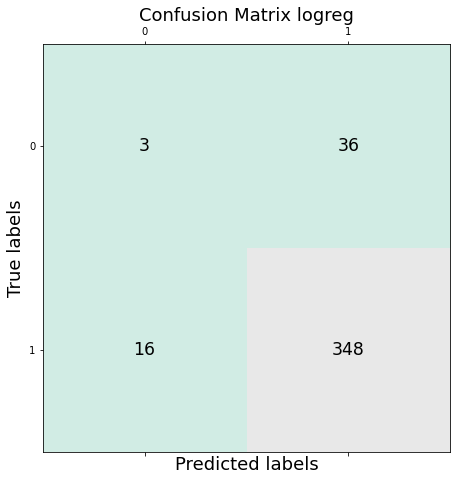

linear_SVC CV Accuracy : 0.9755, Test Accuracy :  0.8660
              precision    recall  f1-score   support

     healthy       0.14      0.08      0.10        39
     tumoral       0.91      0.95      0.93       364

    accuracy                           0.87       403
   macro avg       0.52      0.51      0.51       403
weighted avg       0.83      0.87      0.85       403



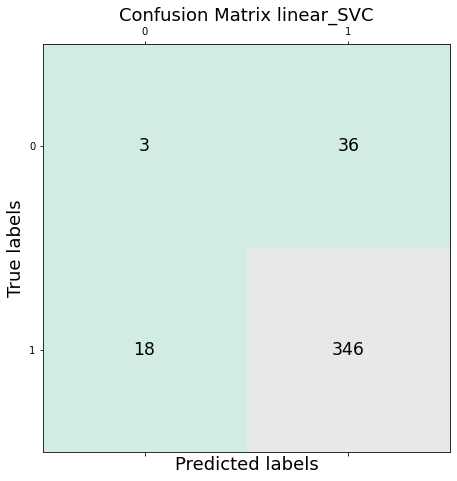

poly_SVC CV Accuracy : 0.9291, Test Accuracy :  0.9231
              precision    recall  f1-score   support

     healthy       0.72      0.33      0.46        39
     tumoral       0.93      0.99      0.96       364

    accuracy                           0.92       403
   macro avg       0.83      0.66      0.71       403
weighted avg       0.91      0.92      0.91       403



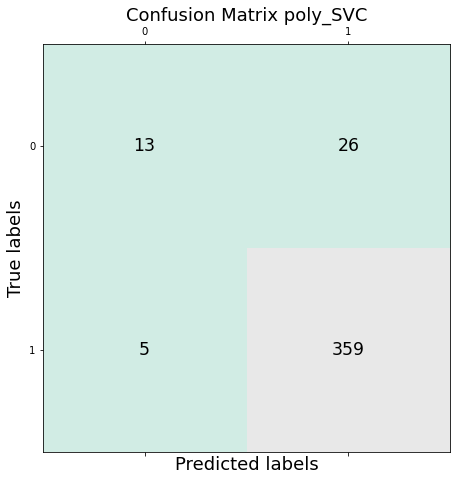

knn CV Accuracy : 0.9573, Test Accuracy :  0.9380
              precision    recall  f1-score   support

     healthy       0.77      0.51      0.62        39
     tumoral       0.95      0.98      0.97       364

    accuracy                           0.94       403
   macro avg       0.86      0.75      0.79       403
weighted avg       0.93      0.94      0.93       403



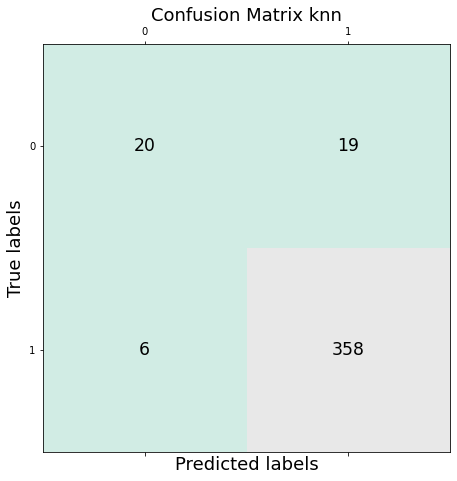

lda CV Accuracy : 0.9878, Test Accuracy :  0.9181
              precision    recall  f1-score   support

     healthy       0.64      0.36      0.46        39
     tumoral       0.93      0.98      0.96       364

    accuracy                           0.92       403
   macro avg       0.79      0.67      0.71       403
weighted avg       0.91      0.92      0.91       403



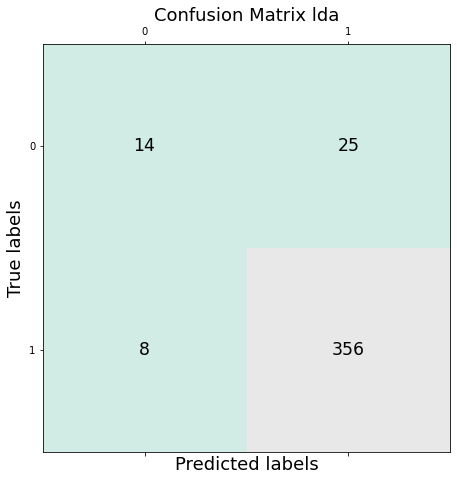

qda CV Accuracy : 0.9817, Test Accuracy :  0.9032
              precision    recall  f1-score   support

     healthy       0.00      0.00      0.00        39
     tumoral       0.90      1.00      0.95       364

    accuracy                           0.90       403
   macro avg       0.45      0.50      0.47       403
weighted avg       0.82      0.90      0.86       403



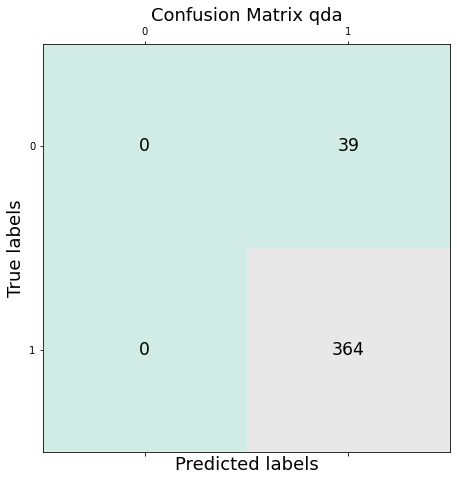

In [32]:
# PCA transformation using non scaled data
pca = PCA(n_components=30)
X_train_pca = pca.fit_transform(X_train_p)
X_test_pca = pca.fit_transform(X_test_p)

#model training
pca_cv_scores = []
pca_accuracy_test_scores= []

for name, model in models.items():
    scores = cross_val_score(model, X_train_pca, y_train.values.ravel(), cv=10, scoring='accuracy')
    pca_cv_score = np.mean(scores)
    pca_cv_scores.append(round(pca_cv_score,2))
    
    #model fit
    model.fit(X_train_pca, y_train.values.ravel())
    y_pred = model.predict(X_test_pca)
    pca_accuracy = np.mean(accuracy_score(y_test,y_pred))
    pca_accuracy_test_scores.append(round(pca_accuracy, 2))
    print("{} CV Accuracy : {:.4f}, Test Accuracy : {: .4f}".format(name, pca_cv_score, pca_accuracy))
    
    #classification report
    print(classification_report(y_test, y_pred, target_names=['healthy', 'tumoral'], zero_division = 0)) 
    df_model = pd.DataFrame(classification_report(y_test, y_pred, 
                                                  target_names=['healthy', 'tumoral'],
                                                  output_dict=True))
    #confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Set2, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predicted labels', fontsize=18)
    plt.ylabel('True labels', fontsize=18)
    plt.title("Confusion Matrix {}".format(name), fontsize=18)
    plt.show()

In general all the models showed good metrics (i.e. precision, recall, fscore and accuracy) for the tumoral samples but the same cannot be said for the healthy samples that had a very bad value for **precision** and the **recall** in almost one half of the model.


Taking into account the metrics, the best models are: 
* Poly SVC;
* KNN;
* LDA.

QDA classified all the samples as 'tumoral' and this is probably due both to the fact that the dataset is very unbalanced and to the fact that features are probabily high correlated between each other.

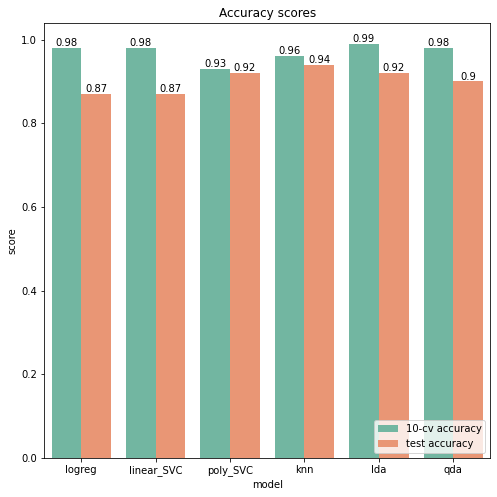

In [33]:
#accuracy plot for PCA
accuracy_plot (pca_cv_scores, pca_accuracy_test_scores) 

The model accuracy are instead very good but they have to be handled carefully.

## 3.2 Multiple Classificator

 logreg CV accuracy : 0.9829 
              precision    recall  f1-score   support

     healthy       0.90      0.97      0.94        39
     tumoral       1.00      0.99      0.99       364

    accuracy                           0.99       403
   macro avg       0.95      0.98      0.97       403
weighted avg       0.99      0.99      0.99       403



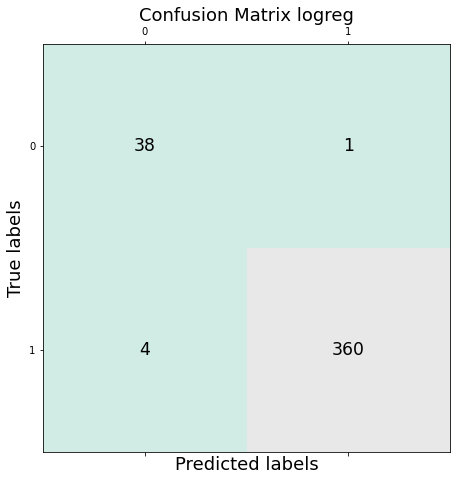

 linear_SVC CV accuracy : 0.9817 
              precision    recall  f1-score   support

     healthy       0.90      0.95      0.92        39
     tumoral       0.99      0.99      0.99       364

    accuracy                           0.99       403
   macro avg       0.95      0.97      0.96       403
weighted avg       0.99      0.99      0.99       403



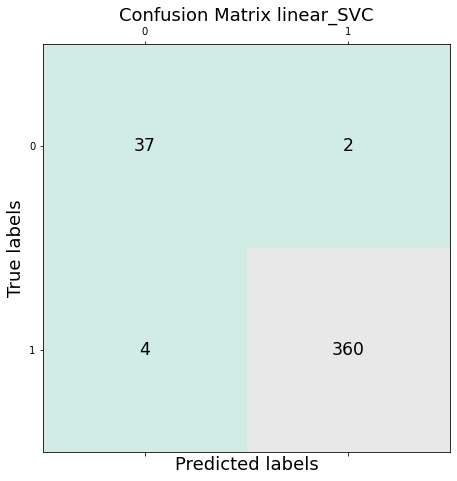

 poly_SVC CV accuracy : 0.9499 
              precision    recall  f1-score   support

     healthy       0.96      0.59      0.73        39
     tumoral       0.96      1.00      0.98       364

    accuracy                           0.96       403
   macro avg       0.96      0.79      0.85       403
weighted avg       0.96      0.96      0.95       403



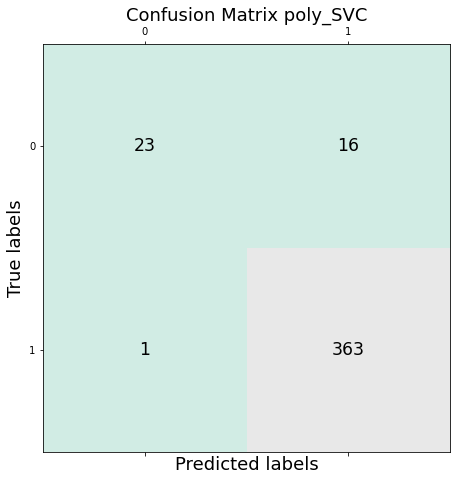

 knn CV accuracy : 0.9609 
              precision    recall  f1-score   support

     healthy       0.83      0.90      0.86        39
     tumoral       0.99      0.98      0.98       364

    accuracy                           0.97       403
   macro avg       0.91      0.94      0.92       403
weighted avg       0.97      0.97      0.97       403



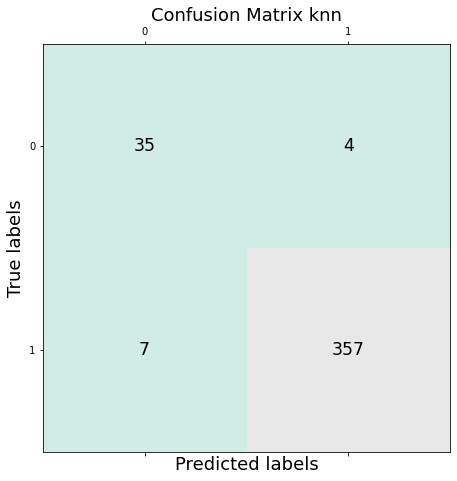

 lda CV accuracy : 0.9939 
              precision    recall  f1-score   support

     healthy       0.97      0.97      0.97        39
     tumoral       1.00      1.00      1.00       364

    accuracy                           1.00       403
   macro avg       0.99      0.99      0.99       403
weighted avg       1.00      1.00      1.00       403



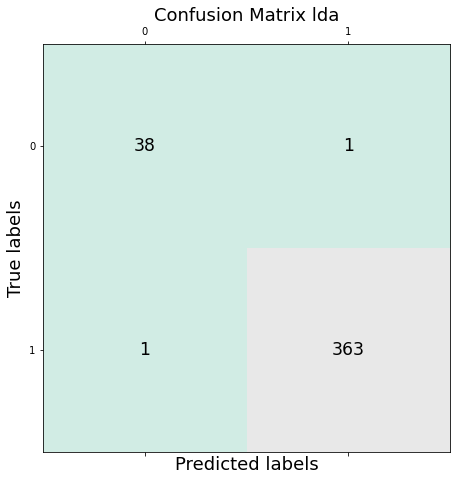

 qda CV accuracy : 0.7726 
              precision    recall  f1-score   support

     healthy       0.10      0.15      0.12        39
     tumoral       0.90      0.84      0.87       364

    accuracy                           0.78       403
   macro avg       0.50      0.50      0.49       403
weighted avg       0.82      0.78      0.80       403



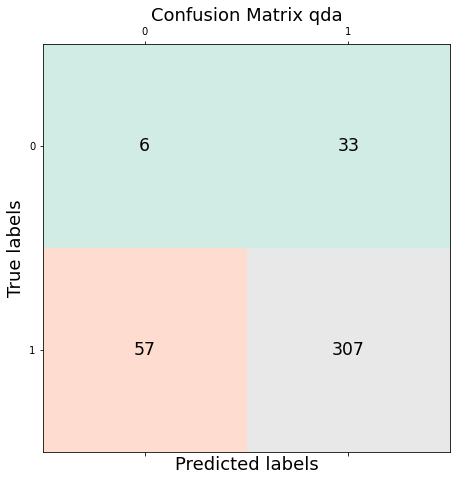

In [34]:
cv_scores= []
accuracy_test_scores = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_p, y_train.values.ravel(), cv=10, scoring='accuracy')
    cv_score = np.mean(scores)
    cv_scores.append(round(cv_score,2))
    
    #model fitting
    model.fit(X_train_p, y_train.values.ravel())
    y_pred = model.predict(X_test_p)
    accuracy = np.mean(accuracy_score(y_test,y_pred))
    accuracy_test_scores.append(round(accuracy, 2))
    print(" {} CV accuracy : {:.4f} ".format(name, cv_score))
    
    #METRICS
    print(classification_report(y_test, y_pred, target_names=['healthy', 'tumoral'])) 
    df_model = pd.DataFrame(classification_report(y_test, y_pred, 
                                                  target_names=['healthy', 'tumoral'],
                                                  output_dict=True))
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Set2, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predicted labels', fontsize=18)
    plt.ylabel('True labels', fontsize=18)
    plt.title("Confusion Matrix {}".format(name), fontsize=18)
    plt.show()

In that case the reults of the metrics are good for both tumor and healthy samples; unfortunately qda did not perform well for the previous explained reasons.

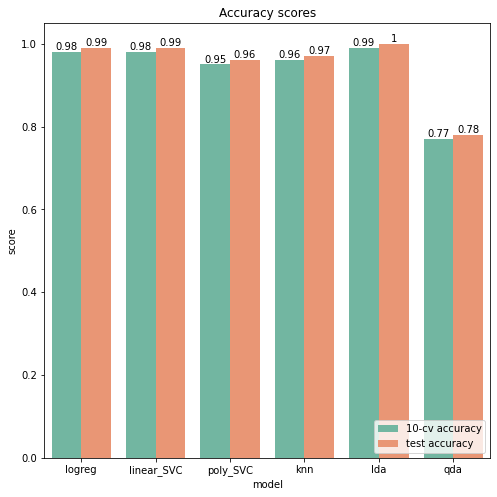

In [35]:
#accuracy plot
accuracy_plot (cv_scores, accuracy_test_scores)

Regarding the accuracy of che CV score, all the models performed more or less as before, only qda got worse.

Even though these values are pretty high and so they are "good", we have to take into account the fact that accuracy is a great measure on symmetric datasets where values are almost the same and it is not the case of this dataset.

## 3.3 Hyper-parameters tuning

Since the performance of a model significantly depends of the value of its hyperparameters in this section we will perform an hyperparameter tuning in order to determine the optinal values for a given model.

To do so, we will use <code>GridSearchCV</code> and we will focus on **KNN** since it was one of the best model in PCA but not among the best in the reduced dataset.

In [36]:
knn = KNeighborsClassifier()
parameters_KNN = {
    'n_neighbors': list(range(5,20)),
    'p': (1,2,3,4),
    'weights': ('uniform', 'distance'),
    'metric': ('minkowski','cosine')
}

# with GridSearch
grid_search_KNN = GridSearchCV(
    estimator=knn,
    param_grid=parameters_KNN,
    scoring = 'accuracy',
    n_jobs = -1,
    cv = 10
)

grid_search_KNN.fit(X_train_p, y_train.values.ravel())


print("The best parametrs are the follwoing:\n",grid_search_KNN.best_params_ ) 
print('\nBest Score - KNN:', grid_search_KNN.best_score_ )

params = grid_search_KNN.best_params_

The best parametrs are the follwoing:
 {'metric': 'minkowski', 'n_neighbors': 6, 'p': 1, 'weights': 'distance'}

Best Score - KNN: 0.9877747666365553


Add the new model into the model list and then evaluate the performance.

In [37]:
#define models
logreg = LogisticRegression(solver='lbfgs', max_iter=10000)
linear_SVC = SVC(kernel='linear', probability = True)
poly_SVC = SVC(kernel='poly', probability =True)
knn_par = KNeighborsClassifier(**params)
lda = LinearDiscriminantAnalysis()
qda = QuadraticDiscriminantAnalysis()

from collections import OrderedDict
models = OrderedDict([('logreg', logreg), ('linear_SVC', linear_SVC), ('poly_SVC', poly_SVC),
                     ('knn_par', knn_par), ('lda', lda), ('qda', qda)])

 logreg CV accuracy : 0.9829 
              precision    recall  f1-score   support

     healthy       0.90      0.97      0.94        39
     tumoral       1.00      0.99      0.99       364

    accuracy                           0.99       403
   macro avg       0.95      0.98      0.97       403
weighted avg       0.99      0.99      0.99       403



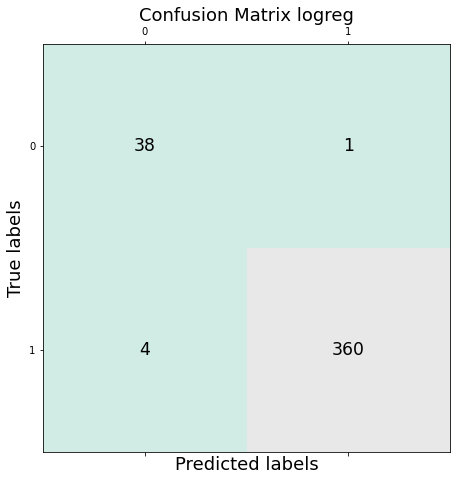

 linear_SVC CV accuracy : 0.9817 
              precision    recall  f1-score   support

     healthy       0.90      0.95      0.92        39
     tumoral       0.99      0.99      0.99       364

    accuracy                           0.99       403
   macro avg       0.95      0.97      0.96       403
weighted avg       0.99      0.99      0.99       403



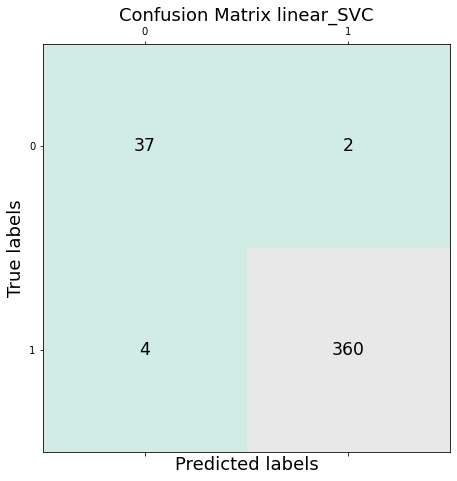

 poly_SVC CV accuracy : 0.9499 
              precision    recall  f1-score   support

     healthy       0.96      0.59      0.73        39
     tumoral       0.96      1.00      0.98       364

    accuracy                           0.96       403
   macro avg       0.96      0.79      0.85       403
weighted avg       0.96      0.96      0.95       403



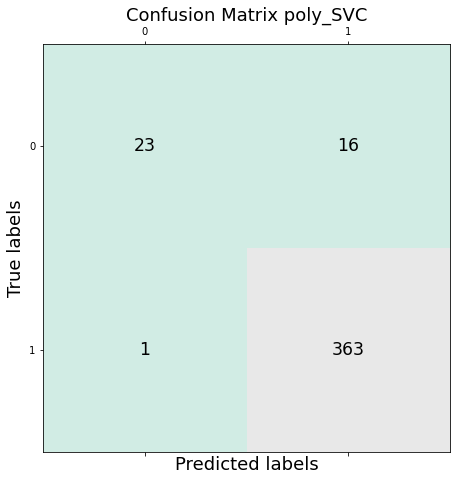

 knn_par CV accuracy : 0.9878 
              precision    recall  f1-score   support

     healthy       0.95      1.00      0.97        39
     tumoral       1.00      0.99      1.00       364

    accuracy                           1.00       403
   macro avg       0.98      1.00      0.99       403
weighted avg       1.00      1.00      1.00       403



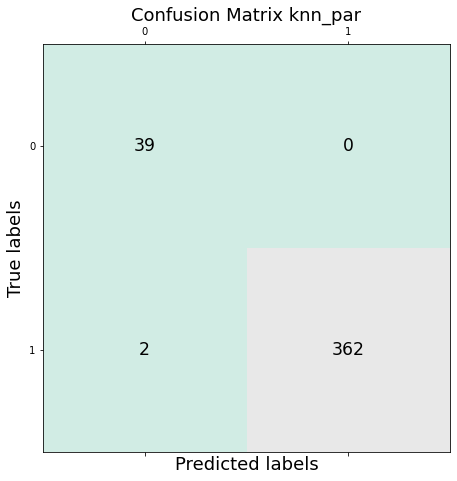

 lda CV accuracy : 0.9939 
              precision    recall  f1-score   support

     healthy       0.97      0.97      0.97        39
     tumoral       1.00      1.00      1.00       364

    accuracy                           1.00       403
   macro avg       0.99      0.99      0.99       403
weighted avg       1.00      1.00      1.00       403



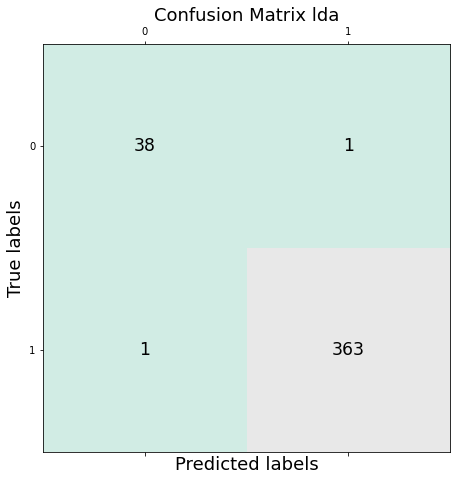

 qda CV accuracy : 0.7726 
              precision    recall  f1-score   support

     healthy       0.10      0.15      0.12        39
     tumoral       0.90      0.84      0.87       364

    accuracy                           0.78       403
   macro avg       0.50      0.50      0.49       403
weighted avg       0.82      0.78      0.80       403



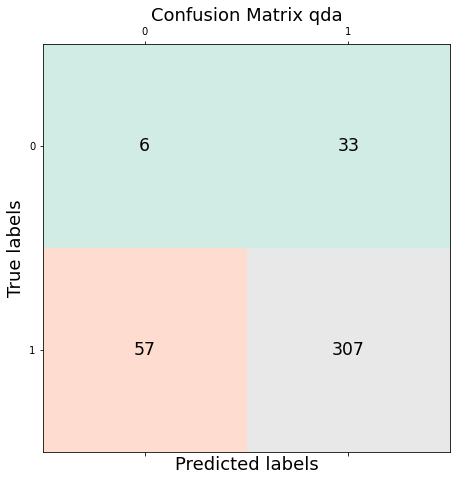

In [38]:
cv_scores_full = []
accuracy_test_scores_full = []

for name, model in models.items():
    scores = cross_val_score(model, X_train_p, y_train.values.ravel(), cv=10, scoring='accuracy')
    cv_score = np.mean(scores)
    cv_scores_full.append(round(cv_score,2))
    
    #model fitting
    model.fit(X_train_p, y_train.values.ravel())
    y_pred = model.predict(X_test_p)
    accuracy = np.mean(accuracy_score(y_test,y_pred))
    accuracy_test_scores_full.append(round(accuracy, 2))
    print(" {} CV accuracy : {:.4f} ".format(name, cv_score))
    
    #METRICS
    print(classification_report(y_test, y_pred, target_names=['healthy', 'tumoral'])) 
    df_model = pd.DataFrame(classification_report(y_test, y_pred, 
                                                  target_names=['healthy', 'tumoral'],
                                                  output_dict=True))
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(cm, cmap=plt.cm.Set2, alpha=0.3)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(x=j, y=i,s=cm[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predicted labels', fontsize=18)
    plt.ylabel('True labels', fontsize=18)
    plt.title("Confusion Matrix {}".format(name), fontsize=18)
    plt.show()

As before all the models metrics are good, in particular is possible to notice that there was an improvement in the **KNN_par** metrics if compared to the not-tuned KNN.
For example, taking into account the healthy samples (minor class), the *precision* score goes from 0.83 to 0.95.

Also qda performed better than before.

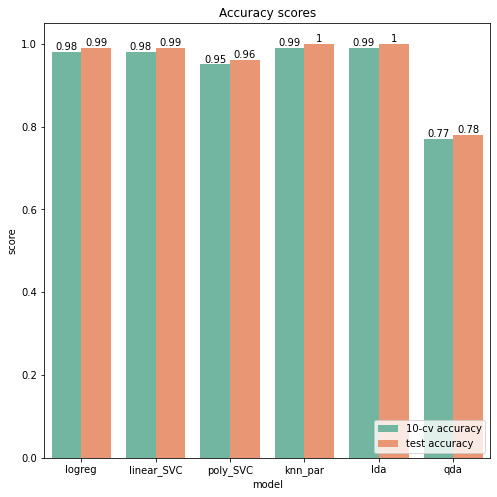

In [39]:
accuracy_plot (cv_scores_full, accuracy_test_scores_full)

The accuracy is high for all the models; focusing on KNN, is possible to notice that this model improved the accuracy score when tuned.

# Conclusion 

The classification of the TGCA-BRCA dataset had very good results both in terms of pure accuracy and other considered metrics.

The model that performed worse is QDA, this is probably due to the fact that this dataset is unbalanced and most of the features are correlated between each other (during the QDA training an error regarding the precence of collinearity raised up).

In general no model clearly outperformed the others but, as seen for the KNN the hyperparameter tuning can have a positive effect on the model performance.

In conclusion is possible to say that the last trained models showed the best performance, while the models traied on PCA reduced dataset are the worst in terms of accuracy related metrics.

## **Thanks for the attention**
*Eleonora Cianini*